In [1]:
# Validation of the steady-state simulation - Case 2: AeroCNN-I
##
## 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
## 2. Using CNN structure to extract geometry features (characteristics)
## 3. The time interval used to train is revolution 10 to 11.
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from scipy import interpolate
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_kernels=400 # Number of filters (kernels) in Convolutional layer
n_units=256 # Number of units in the hidden layer of the MLP network
n_layers=5
input_size = 110 # Size of input for the network (110 coefficients and 3 other parameters, time, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
batch_size = 200 # Mini-batch size
l2_regularizer=1e-07

In [3]:
# The number of revolution
t_lower = 10 # Lower limit of the interval of time
t_upper = 11 # Upper limit of the interval of time

In [4]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [5]:
# Case number: NACA 0018 without Gurney flap - case 0
# the others, which are Case 1,2,4,5,7,8,13,14,15,16,17,18,19,20,21

In [6]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
thickness = 0.02 * h # Thickness of the Gurney flaps
beta = np.linspace(30, 90, 5).reshape((5,1))

beta = beta[-1]

In [7]:
h = h.reshape((-1,1))
thickness = thickness.reshape((-1,1))

In [8]:
t_interval = 0.001
t_len = int((t_upper-t_lower) / t_interval)

n_beta = len(beta)# Number of the Gurney flap inclination
n_h = len(h) # Number of the height of the Gurney flaps

In [9]:
## Creating Input dataset
# Defining time as input

main_directory = 'D:\\VAWT_data'
cm_dir = main_directory + "\\blade_1_cm_data"
cm_list = os.listdir(cm_dir)
os.chdir(cm_dir)

In [10]:
cm_target = [file for file in cm_list if file.endswith('.csv')]
cm_target = sorted(cm_target, key=lambda s: int(re.search(r'\d+',s).group()))
cm_target = cm_target[-10:-7]
n_data = len(cm_target) # Number of txt files from which the aerodynamic coefficients are extracted
n_cases = n_data * t_len # Total number of cases(Number of geometries * Number of angles of attack)

In [11]:
cm_target

['case13cm_blade1.csv', 'case14cm_blade1.csv', 'case15cm_blade1.csv']

In [12]:
### Create input and output data
### This function is the main framework where data are reordered with respect to the shape the NNs require.
### Each input features are made by calling the corresponding functions, which generate the data,
### e.g., time, cm, h, beta, coordinates of airfoil and Gurney flaps, etc.
def genereate_input_output(cm_target, n_beta, t_len, normalize:bool=False):
    
    input_time_cm = time_and_cm(cm_target)
    t = input_time_cm[:,0].reshape((-1, 1))
    cm = input_time_cm[:,1].reshape((-1, 1))
    
    #hh = generate_h(n_beta, t_len, normalize)
    #bb = generate_beta(n_beta, t_len, normalize)
    total_coords = generate_coordinates(n_cases)
    
    # Concatenate data for input dataset
    x_time = t
    x_coord = total_coords.reshape((n_cases,2,10,1))
    
    # Generating output dataset (depending on whether the data be normalized or not)
    if normalize==True:
        y = (cm-np.min(cm))/(np.max(cm)-np.min(cm))
    else:
        y = cm
    print("Dimension - x_time: ", x_time.shape)
    print("Dimension - x_coordinates: ", x_coord.shape)
    print("Dimension - y: ", y.shape)
    
    return x_time, x_coord, y, t, cm

In [13]:
## Creating time for input, and Cm (moment coefficient) for output
def time_and_cm(cm_target):
    cm_df = pd.DataFrame()
    for i, file in enumerate(cm_target):
        df = pd.DataFrame()
        
        data = pd.read_csv(file, header=None)
        df = pd.concat([df, data], axis=0)
        
        time = df.iloc[:,0].values
        cm = df.iloc[:,1].values
        
        time_beUsed = time[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        cm_beUsed = cm[np.where(np.logical_and(time>=t_lower, time<t_upper))]
        
        # Handle the time that is duplicated because of digits
        # Also, outliers are regulated at the second conditional statement.
        time_beUsed = handler_time(time_beUsed)
        cm_beUsed = handler_cm(cm_beUsed)
        
        linear_func = interpolate.interp1d(time_beUsed, cm_beUsed,
                                           bounds_error=False,kind='quadratic',
                                           fill_value='extrapolate')
        time_interp = np.arange(10, 11, t_interval).reshape((-1,1))
        cm_interp=linear_func(time_interp).reshape((-1,1))
        
        cm_df = pd.concat([cm_df, pd.DataFrame(np.hstack((time_interp, cm_interp)))], axis=0)
    
    input_time_cm = cm_df.iloc[:,:].values
    print("Dimension - time and Cm: ", input_time_cm.shape)
    return input_time_cm

In [14]:
# Handling duplicated time value
def handler_time(time_beUsed):
    for i in range(len(time_beUsed)):
        if time_beUsed[i]==time_beUsed[i-1]:
            time_beUsed[i] += 0.0005
            
    return time_beUsed

In [15]:
# Handling outlier, (if there are)
def handler_cm(cm_beUsed):
    period = int(len(cm_beUsed) / 5)
    for i in range(len(cm_beUsed)):
        if np.abs(cm_beUsed[i]-cm_beUsed[i-1])>0.3:
            cm_beUsed[i-1] = cm_beUsed[i-1 + period]
            
    return cm_beUsed

In [16]:
## Defining beta, the Gurney flap inclination
## In case of mere NACA0018, the bb in those indexes are considered as zero.
def generate_beta(n_beta=n_beta, t_len=t_len, normalize=True):

#     beta_0 = np.zeros((t_len,1)) # Values for sheer NACA0018
    b_ = np.ones((t_len,1)) # Template for the inclination for a single h and single beta
    bb_imp = np.zeros((t_len*n_beta,1))

    for j in range(n_beta):
        b_imp = b_ * beta[j]
        bb_imp[t_len*j:t_len*(j+1),:] = b_imp[:,:]

    bb_imp = bb_imp.reshape((-1,1))
    bb = bb_imp
    if normalize==True:
        bb = bb / np.max(beta)
    
    print("Dimension - inclination(beta): ", bb.shape)

    return bb

In [17]:
## Defining the Gurney flap height
## In case of mere NACA0018, the hh in those indexes are considered as zero.
def generate_h(n_beta=n_beta, t_len=t_len, normalize:bool=True):
    #hh = np.concatenate((np.zeros(t_len), h[0]*np.ones(n_beta*t_len), h[1]*np.ones(n_beta*t_len), h[2]*np.ones(n_beta*t_len)))
    hh = h[0]*np.ones(n_beta*t_len)
    hh = hh.reshape((-1,1))
    
    if normalize==True:
        hh = hh / np.max(h)
    
    print("Dimension - heights of Gurney flaps: ", hh.shape)
    return hh

In [18]:
## Generates coordinate data of NACA0018 airfoil and Gurney flaps
## AeroCNN-1: coordinates are replaced with grid data of 2*50 shape.
def generate_coordinates(n_cases):
    origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

    csv_file_name = origin_coord + '\\airfoilOut15.txt'
    data = pd.read_csv(csv_file_name, header=None)
    baseline_coord_high = data.iloc[0,:] # 1*50
    baseline_coord_low = data.iloc[1,:] # 1*50
    baseline_coord = np.vstack((baseline_coord_high, baseline_coord_low)).reshape((2,-1)) # 2*50
    airfoil_coord = np.repeat(baseline_coord, n_cases, axis=0)
    print("Dimension - airfoil coordinates: ", airfoil_coord.shape)
    
    flap_coords= coord_with_flaps(n_cases)
    #total_coords = np.hstack((airfoil_coord, flap_coords))
    total_coords = flap_coords
    
    print("Dimension - total coordinates: ", total_coords.shape)
    
    return total_coords

In [29]:
# Generating data of Gurney flap coordinates
def coord_with_flaps(n_cases):
    flap_left = np.zeros((15,10))
    flap_right = np.zeros((15,10))

    for i in range(n_h):
        # Defining coordinates of the flaps with respect to beta=90 degree.
        yLeft = np.linspace(-h[i]/10, -h[i], 10).reshape((-1,1))
        yRight = np.linspace(-h[i]/10, -h[i], 10).reshape((-1,1))
        xLeft = 0.5*np.ones((10,1)) - 0.02*h[i]
        xRight = 0.5*np.ones((10,1))

        for j, betaValue in enumerate(beta):
            # Rotating transformation
            rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                     [np.sin(90-betaValue), np.cos(90-betaValue)]])
            rotateTransf = rotateTransf.reshape((2,2))

            LeftImp = np.hstack((xLeft-0.5, yLeft))
            RightImp = np.hstack((xRight-0.5, yRight))

            rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
            rotatedFlapRight = rotateTransf @ RightImp.T

            # All we need is the y-coordinates of the flaps
            flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
            flap_right[5*i+j,:] = rotatedFlapRight[1,:]
    
    # flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
    flap_coords = np.vstack((flap_left, flap_right))
    flap_coords2 = np.zeros((n_cases*2,10))
    
    for i in range(t_len, n_cases):
        flap_coords2[i,:] = flap_coords[i%15,:]
    print("Dimension - coord with flaps: ", flap_coords2.shape)
    
    return flap_coords2

In [30]:
# Generating x, y and cm (for denormalizing)
x_time, x_coord, y, t, cm = genereate_input_output(cm_target, n_beta, t_len, normalize=True)

Dimension - time and Cm:  (3000, 2)
Dimension - airfoil coordinates:  (6000, 50)
Dimension - coord with flaps:  (6000, 10)
Dimension - total coordinates:  (6000, 10)
Dimension - x_time:  (3000, 1)
Dimension - x_coordinates:  (3000, 2, 10, 1)
Dimension - y:  (3000, 1)


In [31]:
# x[:,0] -= 10
# x[:,0] /= 5
x_time -= 10

In [32]:
def dataset_split(x_time, x_coord, y, cm, test_rate, random_state=1, **kwargs):
    if kwargs.get('validation')==True:
        val_rate = kwargs.get('val_rate')
        x_time_all, x_time_test, x_coord_all, x_coord_test, y_all, y_test, cm_all, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        x_time_train, x_time_val, x_coord_train, x_coord_val, y_train, y_val, cm_train, cm_val = train_test_split(x_time_all, x_coord_all, y_all, cm_all,
                                                                                                                  test_size=val_rate/(1-test_rate),
                                                                                                                  random_state=kwargs.get('random_state'))
        return x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test
    else:
        x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test = train_test_split(x_time, x_coord, y, cm, test_size=test_rate, random_state=kwargs.get('random_state'))
        return x_time_train, x_time_test, x_coord_train, x_coord_test, y_train, y_test, cm_train, cm_test

In [33]:
x_time_train, x_time_val, x_time_test, x_coord_train, x_coord_val, x_coord_test, y_train, y_val, y_test, cm_train, cm_val, cm_test = dataset_split(x_time,x_coord, y, cm, test_rate, val_rate=val_rate,
                                                                                                                                                   validation=True, random_state=50)

In [41]:
def make_aerocnn1_model(num_layer:int = 1): # This function can only generate model with at least 3 hidden layers
    input_time = tf.keras.Input(shape=1)
    input_coord = tf.keras.Input(shape=(2,10,1))
    
    # The convolutional layer
    x_conv1 = tf.keras.layers.Conv2D(filters=n_kernels, kernel_size=(2,2), strides=1,
                                     padding='same', activation='relu',
                                     name='convLayer',
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(input_coord)
    x_pool = tf.keras.layers.MaxPool2D(pool_size=(2,2))(x_conv1)
    
    x_flat = tf.keras.layers.Flatten()(x_pool)
    x_concat = tf.keras.layers.Concatenate()([x_flat, input_time])

    # The first hidden layer
    x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1',
                                kernel_regularizer=regularizers.l2(l2_regularizer))(x_concat)
    
    # The other hidden layers, which will be placed between the first hidden layer and the last hidden layer.
    # The number of layers that the user desires is input of this function.
    for i in range(0, num_layer-2):
        x_fc = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % (i+2),
                                     kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)
    
    # The last hidden layer
    x_fc_final = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc%d' % num_layer,
                                       kernel_regularizer=regularizers.l2(l2_regularizer))(x_fc)

    # The output layer
    output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc_final)
    
    # MLP(FC layer)-based
    model = tf.keras.Model([input_time, input_coord], output_data)
    
    return model

In [42]:
model = make_aerocnn1_model(num_layer=n_layers)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2, 10, 1)]   0           []                               
                                                                                                  
 convLayer (Conv2D)             (None, 2, 10, 400)   2000        ['input_4[0][0]']                
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 1, 5, 400)   0           ['convLayer[0][0]']              
                                                                                                  
 flatten_1 (Flatten)            (None, 2000)         0           ['max_pooling2d_1[0][0]']        
                                                                                            

In [43]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [44]:
model_directory = "D:\\TrainedModels\\20230103\\3Case(131415)(l2)(flapOnly10Coords)"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [45]:
ckpt_name = model_directory + "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" +str(n_kernels)+ "kernels_" +str(n_layers)+"FClayers_"+ str(n_units) +"units_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=400, min_delta=1e-05,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-05, min_lr=1e-05, verbose=1)

In [46]:
STEP_SIZE_TRAIN = len(x_time_train)//batch_size
VALIDATION_STEPS = len(x_time_val)//batch_size

In [47]:
start = datetime.datetime.now()
history = model.fit([x_time_train, x_coord_train], y_train, batch_size=batch_size,
                    validation_data=[[x_time_val, x_coord_val], y_val],
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
 9/10 [==========================>...] - ETA: 0s - loss: 0.1808 - rmse: 0.4251
Epoch 1: val_loss improved from inf to 0.17669, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 5s 43ms/step - loss: 0.1788 - rmse: 0.4226 - val_loss: 0.1767 - val_rmse: 0.4202 - lr: 1.0000e-04
Epoch 2/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.1583 - rmse: 0.3977
Epoch 2: val_loss improved from 0.17669 to 0.14779, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - loss: 0.1548 - rmse: 0.3933 - val_loss: 0.1478 - val_rmse: 0.3842 - lr: 1.0000e-04
Epoch 3/10000
 6/10 [=================

Epoch 18/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0444 - rmse: 0.2103
Epoch 18: val_loss improved from 0.04716 to 0.04456, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0438 - rmse: 0.2089 - val_loss: 0.0446 - val_rmse: 0.2108 - lr: 1.0000e-04
Epoch 19/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0432 - rmse: 0.2075
Epoch 19: val_loss improved from 0.04456 to 0.04117, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - loss: 0.0428 - rmse: 0.2066 - val_loss: 0.0412 - val_rmse: 0.2026 - lr: 1.0000e-04
Epoch 20/10000
 6/10 [========

Epoch 36/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0051 - rmse: 0.0702
Epoch 36: val_loss improved from 0.00631 to 0.00540, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0050 - rmse: 0.0694 - val_loss: 0.0054 - val_rmse: 0.0725 - lr: 1.0000e-04
Epoch 37/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0044 - rmse: 0.0654
Epoch 37: val_loss improved from 0.00540 to 0.00464, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 23ms/step - loss: 0.0042 - rmse: 0.0639 - val_loss: 0.0046 - val_rmse: 0.0670 - lr: 1.0000e-04
Epoch 38/10000
 6/10 [========

Epoch 55/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0018 - rmse: 0.0413
Epoch 55: val_loss improved from 0.00232 to 0.00204, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 25ms/step - loss: 0.0019 - rmse: 0.0417 - val_loss: 0.0020 - val_rmse: 0.0435 - lr: 1.0000e-04
Epoch 56/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0018 - rmse: 0.0402
Epoch 56: val_loss improved from 0.00204 to 0.00197, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0018 - rmse: 0.0411 - val_loss: 0.0020 - val_rmse: 0.0427 - lr: 1.0000e-04
Epoch 57/10000
 6/10 [========

10/10 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0334 - val_loss: 0.0014 - val_rmse: 0.0359 - lr: 1.0000e-04
Epoch 76/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0013 - rmse: 0.0339
Epoch 76: val_loss did not improve from 0.00143
10/10 [==============================] - 0s 13ms/step - loss: 0.0013 - rmse: 0.0340 - val_loss: 0.0015 - val_rmse: 0.0374 - lr: 1.0000e-04
Epoch 77/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0013 - rmse: 0.0344
Epoch 77: val_loss improved from 0.00143 to 0.00142, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 22ms/step - loss: 0.0013 - rmse: 0.0345 - val_loss: 0.0014 - val_rmse: 0.0358 - lr: 1.0000e-04
Epoch 78/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0012 - rmse: 0.0321
E

10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0013 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 98/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0011 - rmse: 0.0307
Epoch 98: val_loss did not improve from 0.00121
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0308 - val_loss: 0.0013 - val_rmse: 0.0335 - lr: 1.0000e-04
Epoch 99/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0012 - rmse: 0.0318    
Epoch 99: val_loss did not improve from 0.00121
10/10 [==============================] - 0s 13ms/step - loss: 0.0012 - rmse: 0.0320 - val_loss: 0.0013 - val_rmse: 0.0346 - lr: 1.0000e-04
Epoch 100/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0316
Epoch 100: val_loss did not improve from 0.00121
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0317 - val_loss: 0.0012 - val_rmse: 0.0332 - lr: 1.0000e-04
Epoch 101/10

 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0309    
Epoch 124: val_loss did not improve from 0.00113
10/10 [==============================] - 0s 14ms/step - loss: 0.0011 - rmse: 0.0310 - val_loss: 0.0012 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 125/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0305
Epoch 125: val_loss did not improve from 0.00113
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 126/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7497e-04 - rmse: 0.0290
Epoch 126: val_loss improved from 0.00113 to 0.00112, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 21ms/step - loss: 9.8378e-04 - rmse: 0.0292 - val_

Epoch 150/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5262e-04 - rmse: 0.0287
Epoch 150: val_loss did not improve from 0.00108
10/10 [==============================] - 0s 13ms/step - loss: 9.8833e-04 - rmse: 0.0293 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 151/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5954e-04 - rmse: 0.0289
Epoch 151: val_loss did not improve from 0.00108
10/10 [==============================] - 0s 13ms/step - loss: 9.5524e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 152/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2459e-04 - rmse: 0.0282
Epoch 152: val_loss did not improve from 0.00108
10/10 [==============================] - 0s 13ms/step - loss: 9.4903e-04 - rmse: 0.0287 - val_loss: 0.0012 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 153/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4082e-04 - rmse: 0.0285
Epoch 153: val_loss did not 

Epoch 178/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0300
Epoch 178: val_loss did not improve from 0.00106
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 179/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7504e-04 - rmse: 0.0292
Epoch 179: val_loss did not improve from 0.00106
10/10 [==============================] - 0s 13ms/step - loss: 9.8151e-04 - rmse: 0.0293 - val_loss: 0.0011 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 180/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0304    
Epoch 180: val_loss did not improve from 0.00106
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 0.0012 - val_rmse: 0.0328 - lr: 1.0000e-04
Epoch 181/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0312
Epoch 181: val_loss did not improve from 0.0

Epoch 206/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7517e-04 - rmse: 0.0293
Epoch 206: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 13ms/step - loss: 9.4848e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 207/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7633e-04 - rmse: 0.0293
Epoch 207: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 13ms/step - loss: 9.6273e-04 - rmse: 0.0291 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 208/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4472e-04 - rmse: 0.0288
Epoch 208: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 13ms/step - loss: 9.3368e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 209/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0148e-04 - rmse: 0.0280
Epoch 209: val_loss did not 

 7/10 [====================>.........] - ETA: 0s - loss: 9.2063e-04 - rmse: 0.0284
Epoch 234: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 13ms/step - loss: 9.2167e-04 - rmse: 0.0284 - val_loss: 0.0012 - val_rmse: 0.0333 - lr: 1.0000e-04
Epoch 235/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6593e-04 - rmse: 0.0292
Epoch 235: val_loss did not improve from 0.00105
10/10 [==============================] - 0s 13ms/step - loss: 9.3889e-04 - rmse: 0.0287 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 236/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9285e-04 - rmse: 0.0297
Epoch 236: val_loss improved from 0.00105 to 0.00104, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_0.2_test0.1_400kernels_5FClayers_256units_checkpoint.h5
10/10 [==============================] - 0s 20ms/step - loss: 9.8715e-04 - rmse: 0

Epoch 261/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9266e-04 - rmse: 0.0297
Epoch 261: val_loss did not improve from 0.00103
10/10 [==============================] - 0s 13ms/step - loss: 9.4997e-04 - rmse: 0.0290 - val_loss: 0.0011 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 262/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6795e-04 - rmse: 0.0293
Epoch 262: val_loss did not improve from 0.00103
10/10 [==============================] - 0s 13ms/step - loss: 9.5003e-04 - rmse: 0.0290 - val_loss: 0.0012 - val_rmse: 0.0334 - lr: 1.0000e-04
Epoch 263/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.8916e-04 - rmse: 0.0297
Epoch 263: val_loss did not improve from 0.00103
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0299 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 1.0000e-04
Epoch 264/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.6767e-04 - rmse: 0.0293
Epoch 264: val_loss did not impr

10/10 [==============================] - 0s 30ms/step - loss: 0.0010 - rmse: 0.0302 - val_loss: 0.0010 - val_rmse: 0.0300 - lr: 1.0000e-04
Epoch 289/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.3210e-04 - rmse: 0.0288
Epoch 289: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 14ms/step - loss: 8.9199e-04 - rmse: 0.0281 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 290/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.3905e-04 - rmse: 0.0289
Epoch 290: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 15ms/step - loss: 9.1872e-04 - rmse: 0.0285 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 291/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.2827e-04 - rmse: 0.0287
Epoch 291: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 14ms/step - loss: 9.2889e-04 - rmse: 0.0287 - val_loss: 0.0013 - val_rmse: 0.0345 - lr:

Epoch 317/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0301
Epoch 317: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.9364e-04 - rmse: 0.0299 - val_loss: 0.0013 - val_rmse: 0.0343 - lr: 1.0000e-04
Epoch 318/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.9251e-04 - rmse: 0.0299
Epoch 318: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.5821e-04 - rmse: 0.0293 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 319/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2355e-04 - rmse: 0.0287
Epoch 319: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.2872e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 320/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5712e-04 - rmse: 0.0293
Epoch 320: val_loss did not impr

10/10 [==============================] - 0s 14ms/step - loss: 8.8612e-04 - rmse: 0.0281 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 346/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8068e-04 - rmse: 0.0280
Epoch 346: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 8.6530e-04 - rmse: 0.0277 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 347/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1982e-04 - rmse: 0.0287
Epoch 347: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.1618e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 348/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6990e-04 - rmse: 0.0278
Epoch 348: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 8.7243e-04 - rmse: 0.0278 - val_loss: 0.0011 - val_rmse: 0.0314 -

Epoch 373/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8973e-04 - rmse: 0.0282
Epoch 373: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.0675e-04 - rmse: 0.0285 - val_loss: 0.0011 - val_rmse: 0.0313 - lr: 1.0000e-04
Epoch 374/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3426e-04 - rmse: 0.0290
Epoch 374: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.3435e-04 - rmse: 0.0290 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 375/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2332e-04 - rmse: 0.0288
Epoch 375: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 8.9390e-04 - rmse: 0.0283 - val_loss: 0.0011 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 376/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0101e-04 - rmse: 0.0284
Epoch 376: val_loss did not 

10/10 [==============================] - 0s 13ms/step - loss: 8.9871e-04 - rmse: 0.0284 - val_loss: 0.0010 - val_rmse: 0.0304 - lr: 1.0000e-04
Epoch 401/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0254e-04 - rmse: 0.0285
Epoch 401: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.0536e-04 - rmse: 0.0285 - val_loss: 0.0010 - val_rmse: 0.0309 - lr: 1.0000e-04
Epoch 402/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1606e-04 - rmse: 0.0287
Epoch 402: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.7168e-04 - rmse: 0.0297 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 403/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5584e-04 - rmse: 0.0294
Epoch 403: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.2876e-04 - rmse: 0.0289 - val_loss: 0.0011 - val_rmse: 0.0321 -

Epoch 428/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9282e-04 - rmse: 0.0284
Epoch 428: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 8.7900e-04 - rmse: 0.0281 - val_loss: 0.0012 - val_rmse: 0.0329 - lr: 1.0000e-04
Epoch 429/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6023e-04 - rmse: 0.0278
Epoch 429: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 9.1448e-04 - rmse: 0.0287 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 430/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3451e-04 - rmse: 0.0291
Epoch 430: val_loss did not improve from 0.00100
10/10 [==============================] - 0s 13ms/step - loss: 8.9636e-04 - rmse: 0.0284 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 1.0000e-04
Epoch 431/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.5327e-04 - rmse: 0.0294
Epoch 431: val_loss did not 

10/10 [==============================] - 0s 13ms/step - loss: 9.3258e-04 - rmse: 0.0291 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 456/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3594e-04 - rmse: 0.0274
Epoch 456: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 14ms/step - loss: 8.6543e-04 - rmse: 0.0279 - val_loss: 0.0010 - val_rmse: 0.0305 - lr: 1.0000e-04
Epoch 457/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6373e-04 - rmse: 0.0279
Epoch 457: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 8.6195e-04 - rmse: 0.0279 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 458/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.3131e-04 - rmse: 0.0291
Epoch 458: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 9.1450e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0321 -

Epoch 483/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4214e-04 - rmse: 0.0293
Epoch 483: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 9.1651e-04 - rmse: 0.0289 - val_loss: 0.0013 - val_rmse: 0.0354 - lr: 1.0000e-04
Epoch 484/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0305
Epoch 484: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 485/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0304    
Epoch 485: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 9.9354e-04 - rmse: 0.0302 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 486/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.0056e-04 - rmse: 0.0286
Epoch 486: val_loss did not improve 

Epoch 511/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.0261e-04 - rmse: 0.0286
Epoch 511: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 14ms/step - loss: 8.9101e-04 - rmse: 0.0284 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 512/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.4201e-04 - rmse: 0.0293
Epoch 512: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 14ms/step - loss: 9.0216e-04 - rmse: 0.0286 - val_loss: 0.0010 - val_rmse: 0.0303 - lr: 1.0000e-04
Epoch 513/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8224e-04 - rmse: 0.0283
Epoch 513: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 8.5864e-04 - rmse: 0.0279 - val_loss: 0.0011 - val_rmse: 0.0311 - lr: 1.0000e-04
Epoch 514/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5269e-04 - rmse: 0.0295
Epoch 514: val_loss did not 

 7/10 [====================>.........] - ETA: 0s - loss: 8.9122e-04 - rmse: 0.0285
Epoch 539: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 8.8778e-04 - rmse: 0.0284 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 540/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4826e-04 - rmse: 0.0295
Epoch 540: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 9.6729e-04 - rmse: 0.0298 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 541/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0325    
Epoch 541: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0320 - val_loss: 0.0012 - val_rmse: 0.0341 - lr: 1.0000e-04
Epoch 542/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2723e-04 - rmse: 0.0291
Epoch 542: val_loss did not improve from 0.00099

 7/10 [====================>.........] - ETA: 0s - loss: 8.3197e-04 - rmse: 0.0275
Epoch 567: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 14ms/step - loss: 8.4992e-04 - rmse: 0.0278 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 568/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6598e-04 - rmse: 0.0281
Epoch 568: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 8.7911e-04 - rmse: 0.0283 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 569/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9835e-04 - rmse: 0.0286
Epoch 569: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 9.0348e-04 - rmse: 0.0287 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 570/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2320e-04 - rmse: 0.0291
Epoch 570: val_loss did not improve from 0.0

 7/10 [====================>.........] - ETA: 0s - loss: 8.3289e-04 - rmse: 0.0275
Epoch 595: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 8.7477e-04 - rmse: 0.0283 - val_loss: 0.0011 - val_rmse: 0.0318 - lr: 1.0000e-04
Epoch 596/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.7010e-04 - rmse: 0.0282
Epoch 596: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 14ms/step - loss: 8.6159e-04 - rmse: 0.0280 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 597/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7539e-04 - rmse: 0.0283
Epoch 597: val_loss did not improve from 0.00099
10/10 [==============================] - 0s 13ms/step - loss: 9.1125e-04 - rmse: 0.0289 - val_loss: 0.0011 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 598/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7399e-04 - rmse: 0.0282
Epoch 598: val_loss did not improve from 0.0

Epoch 622/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3547e-04 - rmse: 0.0276
Epoch 622: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.2668e-04 - rmse: 0.0274 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 623/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1837e-04 - rmse: 0.0290
Epoch 623: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 9.3093e-04 - rmse: 0.0293 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 624/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8351e-04 - rmse: 0.0284
Epoch 624: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 9.0850e-04 - rmse: 0.0289 - val_loss: 0.0010 - val_rmse: 0.0312 - lr: 1.0000e-04
Epoch 625/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0570e-04 - rmse: 0.0288
Epoch 625: val_loss did not 

 6/10 [=================>............] - ETA: 0s - loss: 8.6470e-04 - rmse: 0.0281
Epoch 650: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 14ms/step - loss: 8.6610e-04 - rmse: 0.0282 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 1.0000e-04
Epoch 651/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8347e-04 - rmse: 0.0285
Epoch 651: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 9.3534e-04 - rmse: 0.0294 - val_loss: 0.0011 - val_rmse: 0.0324 - lr: 1.0000e-04
Epoch 652/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0011 - rmse: 0.0317    
Epoch 652: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 0.0011 - rmse: 0.0315 - val_loss: 0.0012 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 653/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.7836e-04 - rmse: 0.0301
Epoch 653: val_loss did not improve from 0.00097

 7/10 [====================>.........] - ETA: 0s - loss: 9.1151e-04 - rmse: 0.0290
Epoch 678: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.8412e-04 - rmse: 0.0285 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 1.0000e-04
Epoch 679/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0594e-04 - rmse: 0.0289
Epoch 679: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.9006e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 680/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.4437e-04 - rmse: 0.0295
Epoch 680: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 9.5315e-04 - rmse: 0.0297 - val_loss: 9.8421e-04 - val_rmse: 0.0302 - lr: 1.0000e-04
Epoch 681/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0045e-04 - rmse: 0.0288
Epoch 681: val_loss did not improve from

10/10 [==============================] - 0s 13ms/step - loss: 8.8240e-04 - rmse: 0.0285 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 706/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9431e-04 - rmse: 0.0287
Epoch 706: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.7658e-04 - rmse: 0.0284 - val_loss: 0.0012 - val_rmse: 0.0339 - lr: 1.0000e-04
Epoch 707/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6475e-04 - rmse: 0.0282
Epoch 707: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.6618e-04 - rmse: 0.0282 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 1.0000e-04
Epoch 708/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1923e-04 - rmse: 0.0291
Epoch 708: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.8225e-04 - rmse: 0.0285 - val_loss: 9.8902e-04 - val_rmse: 0.03

Epoch 734/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.5763e-04 - rmse: 0.0298
Epoch 734: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 9.7240e-04 - rmse: 0.0300 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 1.0000e-04
Epoch 735/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.9794e-04 - rmse: 0.0288
Epoch 735: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.8774e-04 - rmse: 0.0286 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 736/10000
 6/10 [=================>............] - ETA: 0s - loss: 0.0010 - rmse: 0.0305    
Epoch 736: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 9.6557e-04 - rmse: 0.0299 - val_loss: 0.0012 - val_rmse: 0.0338 - lr: 1.0000e-04
Epoch 737/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5649e-04 - rmse: 0.0281
Epoch 737: val_loss did not 

 6/10 [=================>............] - ETA: 0s - loss: 9.5043e-04 - rmse: 0.0297
Epoch 762: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 14ms/step - loss: 9.0748e-04 - rmse: 0.0290 - val_loss: 0.0011 - val_rmse: 0.0317 - lr: 1.0000e-04
Epoch 763/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.9493e-04 - rmse: 0.0270
Epoch 763: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.1069e-04 - rmse: 0.0272 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 1.0000e-04
Epoch 764/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.2206e-04 - rmse: 0.0292
Epoch 764: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.6161e-04 - rmse: 0.0282 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 765/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5818e-04 - rmse: 0.0281
Epoch 765: val_loss did not improve from 0.0

 7/10 [====================>.........] - ETA: 0s - loss: 8.4840e-04 - rmse: 0.0279
Epoch 790: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.5403e-04 - rmse: 0.0280 - val_loss: 0.0012 - val_rmse: 0.0331 - lr: 1.0000e-04
Epoch 791/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.0963e-04 - rmse: 0.0290
Epoch 791: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.7749e-04 - rmse: 0.0285 - val_loss: 0.0011 - val_rmse: 0.0320 - lr: 1.0000e-04
Epoch 792/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5699e-04 - rmse: 0.0281
Epoch 792: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.5216e-04 - rmse: 0.0280 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 1.0000e-04
Epoch 793/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3507e-04 - rmse: 0.0277
Epoch 793: val_loss did not improve from 0.0

Epoch 818/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5347e-04 - rmse: 0.0281
Epoch 818: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 7.9582e-04 - rmse: 0.0270 - val_loss: 0.0011 - val_rmse: 0.0314 - lr: 5.0000e-05
Epoch 819/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7090e-04 - rmse: 0.0284
Epoch 819: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.7211e-04 - rmse: 0.0284 - val_loss: 9.7947e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 820/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0605e-04 - rmse: 0.0272
Epoch 820: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 7.8344e-04 - rmse: 0.0268 - val_loss: 9.7831e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 821/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7440e-04 - rmse: 0.0284
Epoch 821: val_loss 

 7/10 [====================>.........] - ETA: 0s - loss: 8.3789e-04 - rmse: 0.0278
Epoch 845: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.4178e-04 - rmse: 0.0279 - val_loss: 9.7306e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 846/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.5430e-04 - rmse: 0.0281
Epoch 846: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.3343e-04 - rmse: 0.0277 - val_loss: 0.0011 - val_rmse: 0.0323 - lr: 5.0000e-05
Epoch 847/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0668e-04 - rmse: 0.0272
Epoch 847: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.2577e-04 - rmse: 0.0276 - val_loss: 9.8964e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 848/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3090e-04 - rmse: 0.0277
Epoch 848: val_loss did not improve 

Epoch 872/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4807e-04 - rmse: 0.0280
Epoch 872: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.5070e-04 - rmse: 0.0280 - val_loss: 9.9152e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 873/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2857e-04 - rmse: 0.0276
Epoch 873: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.3427e-04 - rmse: 0.0277 - val_loss: 9.8215e-04 - val_rmse: 0.0303 - lr: 5.0000e-05
Epoch 874/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4506e-04 - rmse: 0.0279
Epoch 874: val_loss did not improve from 0.00097
10/10 [==============================] - 0s 13ms/step - loss: 8.1455e-04 - rmse: 0.0274 - val_loss: 9.7636e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 875/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6257e-04 - rmse: 0.0282
Epoch 875: val_l

Epoch 899/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8382e-04 - rmse: 0.0286
Epoch 899: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.9286e-04 - rmse: 0.0288 - val_loss: 9.6762e-04 - val_rmse: 0.0300 - lr: 5.0000e-05
Epoch 900/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8472e-04 - rmse: 0.0286
Epoch 900: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.9102e-04 - rmse: 0.0287 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 5.0000e-05
Epoch 901/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7405e-04 - rmse: 0.0284
Epoch 901: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.4742e-04 - rmse: 0.0280 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 5.0000e-05
Epoch 902/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5418e-04 - rmse: 0.0281
Epoch 902: val_loss did 

 7/10 [====================>.........] - ETA: 0s - loss: 8.6907e-04 - rmse: 0.0284
Epoch 927: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.3520e-04 - rmse: 0.0278 - val_loss: 9.8846e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 928/10000
 7/10 [====================>.........] - ETA: 0s - loss: 0.0010 - rmse: 0.0311
Epoch 928: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 0.0010 - rmse: 0.0309 - val_loss: 0.0011 - val_rmse: 0.0319 - lr: 5.0000e-05
Epoch 929/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4442e-04 - rmse: 0.0279
Epoch 929: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 9.0027e-04 - rmse: 0.0289 - val_loss: 9.8992e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 930/10000
 7/10 [====================>.........] - ETA: 0s - loss: 9.1575e-04 - rmse: 0.0292
Epoch 930: val_loss did not improve from 0.0

10/10 [==============================] - 0s 13ms/step - loss: 8.2115e-04 - rmse: 0.0275 - val_loss: 9.7442e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 955/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3404e-04 - rmse: 0.0277
Epoch 955: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 14ms/step - loss: 8.4098e-04 - rmse: 0.0279 - val_loss: 9.7572e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 956/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.2816e-04 - rmse: 0.0276
Epoch 956: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 15ms/step - loss: 8.4584e-04 - rmse: 0.0280 - val_loss: 9.9323e-04 - val_rmse: 0.0305 - lr: 5.0000e-05
Epoch 957/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.6326e-04 - rmse: 0.0283
Epoch 957: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 14ms/step - loss: 8.1922e-04 - rmse: 0.0275 - val_loss: 9.7559e-04 - va

10/10 [==============================] - 0s 13ms/step - loss: 8.8420e-04 - rmse: 0.0286 - val_loss: 9.7522e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 983/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.8857e-04 - rmse: 0.0269
Epoch 983: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.0731e-04 - rmse: 0.0273 - val_loss: 9.9721e-04 - val_rmse: 0.0306 - lr: 5.0000e-05
Epoch 984/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4800e-04 - rmse: 0.0280
Epoch 984: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.1574e-04 - rmse: 0.0274 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 5.0000e-05
Epoch 985/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.9326e-04 - rmse: 0.0288
Epoch 985: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 14ms/step - loss: 9.1575e-04 - rmse: 0.0292 - val_loss: 0.0010 - val_rmse: 

10/10 [==============================] - 0s 13ms/step - loss: 8.4665e-04 - rmse: 0.0280 - val_loss: 9.9919e-04 - val_rmse: 0.0306 - lr: 5.0000e-05
Epoch 1011/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0721e-04 - rmse: 0.0273
Epoch 1011: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.0351e-04 - rmse: 0.0272 - val_loss: 0.0010 - val_rmse: 0.0306 - lr: 5.0000e-05
Epoch 1012/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1683e-04 - rmse: 0.0274
Epoch 1012: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.1290e-04 - rmse: 0.0274 - val_loss: 9.7010e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 1013/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0270e-04 - rmse: 0.0272
Epoch 1013: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 14ms/step - loss: 8.4948e-04 - rmse: 0.0280 - val_loss: 9.9103e-04 - 

 7/10 [====================>.........] - ETA: 0s - loss: 8.0632e-04 - rmse: 0.0273
Epoch 1038: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.4466e-04 - rmse: 0.0280 - val_loss: 9.7160e-04 - val_rmse: 0.0301 - lr: 5.0000e-05
Epoch 1039/10000
 6/10 [=================>............] - ETA: 0s - loss: 7.5458e-04 - rmse: 0.0263
Epoch 1039: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 14ms/step - loss: 7.7409e-04 - rmse: 0.0267 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 5.0000e-05
Epoch 1040/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1403e-04 - rmse: 0.0292
Epoch 1040: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 14ms/step - loss: 8.9520e-04 - rmse: 0.0288 - val_loss: 0.0011 - val_rmse: 0.0316 - lr: 5.0000e-05
Epoch 1041/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.8978e-04 - rmse: 0.0270
Epoch 1041: val_loss did not impro

 7/10 [====================>.........] - ETA: 0s - loss: 8.2756e-04 - rmse: 0.0277
Epoch 1065: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.0060e-04 - rmse: 0.0272 - val_loss: 9.8168e-04 - val_rmse: 0.0303 - lr: 5.0000e-05
Epoch 1066/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.6875e-04 - rmse: 0.0284
Epoch 1066: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.6752e-04 - rmse: 0.0284 - val_loss: 9.7329e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 1067/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5997e-04 - rmse: 0.0282
Epoch 1067: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.2791e-04 - rmse: 0.0277 - val_loss: 9.9366e-04 - val_rmse: 0.0305 - lr: 5.0000e-05
Epoch 1068/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2632e-04 - rmse: 0.0276
Epoch 1068: val_loss did n

Epoch 1093/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2575e-04 - rmse: 0.0276
Epoch 1093: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.4934e-04 - rmse: 0.0281 - val_loss: 0.0011 - val_rmse: 0.0315 - lr: 5.0000e-05
Epoch 1094/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7317e-04 - rmse: 0.0285
Epoch 1094: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.7061e-04 - rmse: 0.0284 - val_loss: 9.8784e-04 - val_rmse: 0.0304 - lr: 5.0000e-05
Epoch 1095/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1080e-04 - rmse: 0.0274
Epoch 1095: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 7.8029e-04 - rmse: 0.0268 - val_loss: 9.6492e-04 - val_rmse: 0.0300 - lr: 5.0000e-05
Epoch 1096/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.5187e-04 - rmse: 0.0281
Epoch 1096: v

Epoch 1121/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.9569e-04 - rmse: 0.0271
Epoch 1121: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.0777e-04 - rmse: 0.0273 - val_loss: 9.5925e-04 - val_rmse: 0.0300 - lr: 5.0000e-05
Epoch 1122/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3642e-04 - rmse: 0.0278
Epoch 1122: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.6671e-04 - rmse: 0.0284 - val_loss: 9.7132e-04 - val_rmse: 0.0302 - lr: 5.0000e-05
Epoch 1123/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2309e-04 - rmse: 0.0276
Epoch 1123: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.3583e-04 - rmse: 0.0278 - val_loss: 9.9102e-04 - val_rmse: 0.0305 - lr: 5.0000e-05
Epoch 1124/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.5358e-04 - rmse: 0.0281
Epoch 112

10/10 [==============================] - 0s 14ms/step - loss: 8.5614e-04 - rmse: 0.0282 - val_loss: 9.6668e-04 - val_rmse: 0.0301 - lr: 2.5000e-05
Epoch 1149/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.1290e-04 - rmse: 0.0274
Epoch 1149: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 7.9798e-04 - rmse: 0.0271 - val_loss: 9.5805e-04 - val_rmse: 0.0299 - lr: 2.5000e-05
Epoch 1150/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.4540e-04 - rmse: 0.0280
Epoch 1150: val_loss did not improve from 0.00096
10/10 [==============================] - 0s 13ms/step - loss: 8.5381e-04 - rmse: 0.0281 - val_loss: 0.0010 - val_rmse: 0.0307 - lr: 2.5000e-05
Epoch 1151/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.4659e-04 - rmse: 0.0262
Epoch 1151: val_loss improved from 0.00096 to 0.00095, saving model to D:\TrainedModels\20230103\3Case(131415)(l2)(flapOnly10Coords)20230103unsteady_AeroCNN1_3Case

Epoch 1176/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0888e-04 - rmse: 0.0273
Epoch 1176: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.0388e-04 - rmse: 0.0273 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 2.5000e-05
Epoch 1177/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3542e-04 - rmse: 0.0278
Epoch 1177: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.2468e-04 - rmse: 0.0276 - val_loss: 9.7888e-04 - val_rmse: 0.0303 - lr: 2.5000e-05
Epoch 1178/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3800e-04 - rmse: 0.0279
Epoch 1178: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.2434e-04 - rmse: 0.0276 - val_loss: 9.6138e-04 - val_rmse: 0.0300 - lr: 2.5000e-05
Epoch 1179/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2335e-04 - rmse: 0.0276
Epoch 1179: v

Epoch 1204/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2724e-04 - rmse: 0.0277
Epoch 1204: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.0596e-04 - rmse: 0.0273 - val_loss: 9.7486e-04 - val_rmse: 0.0302 - lr: 2.5000e-05
Epoch 1205/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7308e-04 - rmse: 0.0285
Epoch 1205: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.4285e-04 - rmse: 0.0280 - val_loss: 9.9158e-04 - val_rmse: 0.0305 - lr: 2.5000e-05
Epoch 1206/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.6551e-04 - rmse: 0.0265
Epoch 1206: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 7.7237e-04 - rmse: 0.0267 - val_loss: 9.7445e-04 - val_rmse: 0.0302 - lr: 2.5000e-05
Epoch 1207/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7414e-04 - rmse: 0.0285
Epoch 120

Epoch 1232/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.8242e-04 - rmse: 0.0269
Epoch 1232: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.0900e-04 - rmse: 0.0274 - val_loss: 9.6449e-04 - val_rmse: 0.0301 - lr: 2.5000e-05
Epoch 1233/10000
 6/10 [=================>............] - ETA: 0s - loss: 8.3571e-04 - rmse: 0.0278
Epoch 1233: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 14ms/step - loss: 8.0879e-04 - rmse: 0.0273 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 2.5000e-05
Epoch 1234/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.0960e-04 - rmse: 0.0274
Epoch 1234: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.1473e-04 - rmse: 0.0275 - val_loss: 9.8941e-04 - val_rmse: 0.0305 - lr: 2.5000e-05
Epoch 1235/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7091e-04 - rmse: 0.0285
Epoch 1235: v

Epoch 1260/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2216e-04 - rmse: 0.0276
Epoch 1260: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.2095e-04 - rmse: 0.0276 - val_loss: 9.7084e-04 - val_rmse: 0.0302 - lr: 2.5000e-05
Epoch 1261/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.8504e-04 - rmse: 0.0287
Epoch 1261: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.9903e-04 - rmse: 0.0290 - val_loss: 9.9409e-04 - val_rmse: 0.0306 - lr: 2.5000e-05
Epoch 1262/10000
 6/10 [=================>............] - ETA: 0s - loss: 7.9467e-04 - rmse: 0.0271
Epoch 1262: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 14ms/step - loss: 8.6687e-04 - rmse: 0.0284 - val_loss: 0.0010 - val_rmse: 0.0308 - lr: 2.5000e-05
Epoch 1263/10000
 7/10 [====================>.........] - ETA: 0s - loss: 7.7232e-04 - rmse: 0.0267
Epoch 1263: v

Epoch 1288/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3337e-04 - rmse: 0.0278
Epoch 1288: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.1059e-04 - rmse: 0.0274 - val_loss: 9.7326e-04 - val_rmse: 0.0302 - lr: 2.5000e-05
Epoch 1289/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7736e-04 - rmse: 0.0286
Epoch 1289: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.4805e-04 - rmse: 0.0281 - val_loss: 0.0010 - val_rmse: 0.0313 - lr: 2.5000e-05
Epoch 1290/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3336e-04 - rmse: 0.0278
Epoch 1290: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.3431e-04 - rmse: 0.0278 - val_loss: 0.0010 - val_rmse: 0.0310 - lr: 2.5000e-05
Epoch 1291/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3329e-04 - rmse: 0.0278
Epoch 1291: val_l

Epoch 1315/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.2129e-04 - rmse: 0.0276
Epoch 1315: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.1221e-04 - rmse: 0.0274 - val_loss: 9.6049e-04 - val_rmse: 0.0300 - lr: 2.5000e-05
Epoch 1316/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.7580e-04 - rmse: 0.0286
Epoch 1316: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.3078e-04 - rmse: 0.0278 - val_loss: 0.0011 - val_rmse: 0.0328 - lr: 2.5000e-05
Epoch 1317/10000
 6/10 [=================>............] - ETA: 0s - loss: 9.1105e-04 - rmse: 0.0292
Epoch 1317: val_loss did not improve from 0.00095
10/10 [==============================] - 0s 13ms/step - loss: 8.7749e-04 - rmse: 0.0286 - val_loss: 9.8589e-04 - val_rmse: 0.0304 - lr: 2.5000e-05
Epoch 1318/10000
 7/10 [====================>.........] - ETA: 0s - loss: 8.3879e-04 - rmse: 0.0279
Epoch 1318: v


Epoch 1342: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
10/10 [==============================] - 0s 14ms/step - loss: 7.9170e-04 - rmse: 0.0270 - val_loss: 9.7954e-04 - val_rmse: 0.0303 - lr: 2.5000e-05
Epoch 1342: early stopping


In [48]:
time = end - start
print("Training time:", time)

Training time: 0:03:11.384398


In [49]:
storage_dir = "D:\\VAWT_data\\flap_unsteady\\result\\"+"20230103_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_WithParameters\\test"+str(test_rate)+"_val"+str(val_rate)+"_"+str(n_kernels)+"kernels_"+str(n_layers)+"layers_"+ str(n_units) +"units_CmPrediction"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

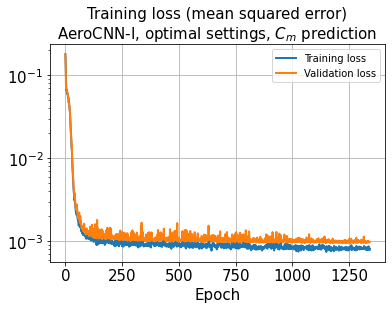

In [50]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nAeroCNN-I, optimal settings, $C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

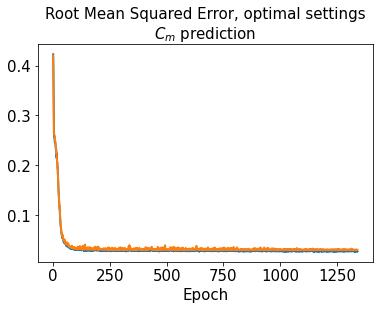

In [51]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

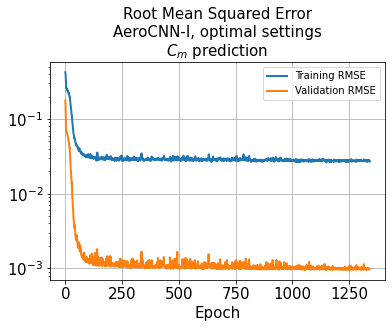

In [52]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nAeroCNN-I, optimal settings\n$C_m$ prediction', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [53]:
train_results = model.evaluate([x_time_train, x_coord_train], y_train)

66/66 [==============================] - 0s 4ms/step - loss: 8.2277e-04 - rmse: 0.0275


In [54]:
val_results = model.evaluate([x_time_val, x_coord_val], y_val)

19/19 [==============================] - 0s 5ms/step - loss: 9.5895e-04 - rmse: 0.0299


In [55]:
test_results = model.evaluate([x_time_test, x_coord_test], y_test)

10/10 [==============================] - 0s 6ms/step - loss: 9.1737e-04 - rmse: 0.0292


In [56]:
decoded_train_ = model.predict([x_time_train, x_coord_train])
decoded_val_ = model.predict([x_time_val, x_coord_val])
decoded_test_ = model.predict([x_time_test, x_coord_test])

10/10 [==============================] - 0s 2ms/step


In [57]:
def define_index(y_total, y_partial):
    return np.unique(np.where(np.isin(y_total, y_partial)))

In [58]:
def error_absolute(y_pred, y_true):
    return np.abs(y_pred - y_true)

In [59]:
# Denormalize 
def denormalize(y):
    return y*(np.max(cm)-np.min(cm))+np.min(cm)

In [60]:
def l2_error(y_pred, y_real):
    return np.sqrt(np.sum((y_pred - y_real)**2) / np.sum(y_real**2))

def mape(y_pred, y_real):
    return 100/len(y_real) * np.sum(np.abs((y_real-y_pred)/y_real))

def smape(y_pred, y_real):
    return 100*np.sum(np.abs(y_pred-y_real))/np.sum(y_real + y_pred)

In [61]:
index_train = define_index(y, y_train)
index_val = define_index(y, y_val)
index_test = define_index(y, y_test)

In [62]:
l2_error_train = l2_error(decoded_train_, y_train)
mape_train = smape(decoded_train_, y_train)
print(l2_error_train)
print(mape_train)

0.06323973304510863
2.453054342062571


In [63]:
l2_error_val = l2_error(decoded_val_, y_val)
mape_val= smape(decoded_val_, y_val)
print(l2_error_val)
print(mape_val)

0.06709533030700002
2.5622118590750986


In [64]:
l2_error_test = l2_error(decoded_test_, y_test)
mape_test= smape(decoded_test_, y_test)
print(l2_error_test)
print(mape_test)

0.06984895266863624
2.6771721373803095


In [65]:
y_train = denormalize(y_train)
y_val = denormalize(y_val)
y_test = denormalize(y_test)

In [66]:
decoded_train = denormalize(decoded_train_)
decoded_val = denormalize(decoded_val_)
decoded_test = denormalize(decoded_test_)

In [67]:
model_directory = "D:\\TrainedModels\\20230103"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20230103unsteady_AeroCNN1_3Case(131415)(l2)(flapOnly10Coords)_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_kernels)+"kernels_" + str(n_layers) +"layers_"+str(n_units)+"units_CmPrediction.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [68]:
error_train_abs = error_absolute(decoded_train, y_train)
error_val_abs = error_absolute(decoded_val, y_val)
error_test_abs = error_absolute(decoded_test, y_test)

In [69]:
os.chdir(storage_dir)

In [70]:
l2_error_train_list = []
for i in range(0, len(x_time_train)):
    l2_error_train_data = l2_error(decoded_train[i], y_train[i])
    l2_error_train_list.append(l2_error_train_data)

In [71]:
l2_error_val_list = []
for i in range(0, len(x_time_val)):
    l2_error_val_data = l2_error(decoded_val[i], y_val[i])
    l2_error_val_list.append(l2_error_val_data)

In [72]:
l2_error_test_list = []
for i in range(0, len(x_time_test)):
    l2_error_test_data = l2_error(decoded_test[i], y_test[i])
    l2_error_test_list.append(l2_error_test_data)

In [73]:
mape_train_list = []
for i in range(0, len(x_time_train)):
    mape_train_data = smape(decoded_train[i], y_train[i])
    mape_train_list.append(mape_train_data)

In [74]:
mape_val_list = []
for i in range(0, len(x_time_val)):
    mape_val_data = smape(decoded_val[i], y_val[i])
    mape_val_list.append(mape_val_data)

In [75]:
mape_test_list = []
for i in range(0, len(x_time_test)):
    mape_test_data = smape(decoded_test[i], y_test[i])
    mape_test_list.append(mape_test_data)

In [76]:
def distribution_plot(y_pred, y_real, dataset="train"):
    dictionary_name = {"train":"training", "val":"validation", "test":"test"}
    dictionary_data = {"train":l2_error_train_list, "val":l2_error_val_list, "test":l2_error_test_list}
    dictionary_error = {"train":l2_error_train, "val":l2_error_val, "test":l2_error_test}
    plot_title = '$L_2$ error norm distribution - MLP, unsteady, '+ dictionary_name.get(dataset) +'.\nValidation rate {0}, test rate {1}, {2} layers, {3} units ($C_m$)'.format(
        val_rate, test_rate, n_layers, n_units)
    plt.plot(np.linspace(1,y_real.shape[0],y_real.shape[0]),
             dictionary_error.get(dataset)*np.ones(y_real.shape[0],), 'k', lw=2.5)
    plt.scatter(np.linspace(1, y_real.shape[0], y_real.shape[0]), dictionary_data.get(dataset), c='b')
    plt.xlabel('Index', fontsize=15)
    plt.ylabel('$L_2$ error norm', fontsize=15)
    plt.yscale('log')
    plt.title(plot_title, fontsize=15)
    plt.grid()

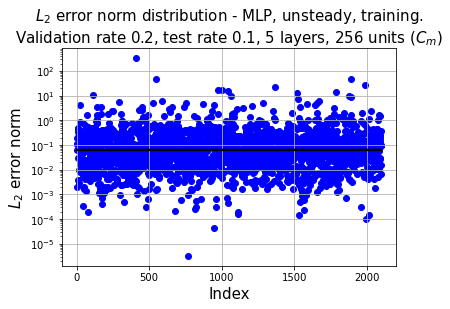

In [77]:
distribution_plot(decoded_train, y_train, dataset="train")
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

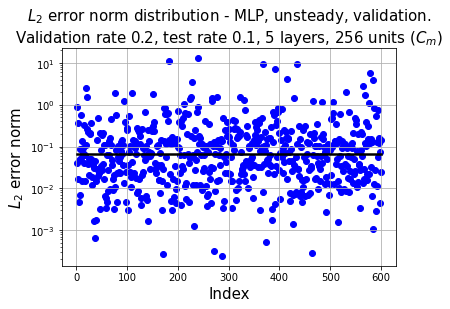

In [78]:
distribution_plot(decoded_val, y_val, dataset="val")
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

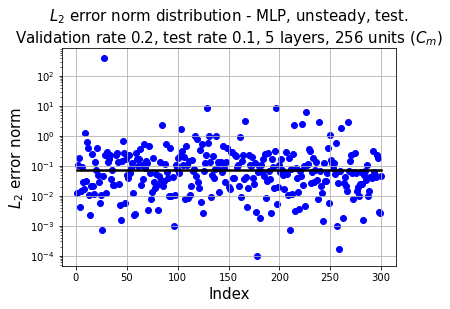

In [79]:
distribution_plot(decoded_test, y_test, dataset="test")
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [80]:
predicted = model.predict([x_time, x_coord])

94/94 [==============================] - 0s 2ms/step


In [81]:
tTrain = x_time[index_train] + 10
tVal = x_time[index_val] + 10
tTest = x_time[index_test] + 10

In [82]:
max(predicted)

array([0.9602978], dtype=float32)

In [83]:
print(l2_error(predicted, y))

0.06469427226683694


In [84]:
cm[2000]

array([0.00682824])

In [85]:
cm[1000]

array([0.0014248])

In [86]:
# Each set of data in sorted order
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for k , index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [87]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [88]:
t

array([[0.   ],
       [0.001],
       [0.002],
       ...,
       [0.997],
       [0.998],
       [0.999]])

In [89]:
def Cm_trainTestSplit_Plot(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'k--', label='Predicted value')
    plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
    plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
    plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([-0.05, 0.22])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

In [90]:
len(predicted[index_train])

2101

In [91]:
len(predicted[index_val])

600

In [92]:
len(predicted[index_test])

301

In [93]:
x_time += 10

L2 error of Cm: 0.0711


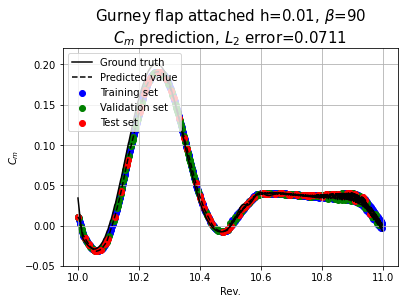

L2 error of Cm: 0.0156


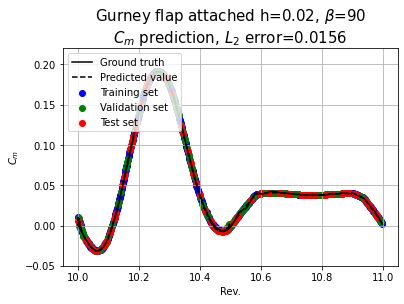

L2 error of Cm: 0.0857


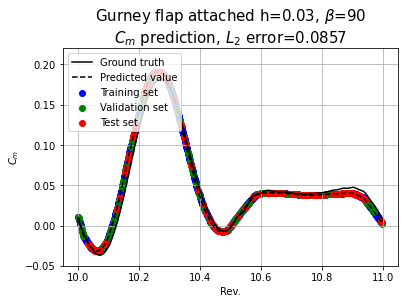

In [94]:
h = [0.01, 0.02, 0.03]
beta = [90, 90, 90]
for i in range(0,3):
    #Index from each dataset in sorted order
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

In [95]:
def Cm_trainTestSplit_Plot2(i, Cm, cm, tTrain, tVal, tTest, iTrain, iVal, iTest):
    
    title_0_Cm = 'Gurney flap not attached (NACA0018)\n$C_m$ prediction, $L_2$ error=%.4f' % l2_error_Cm    
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    if i==0:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    else:
        title_Cm = title_n_Cm
        savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # Cm graph plot
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm), 'r--', label='Predicted value')
#     plt.scatter(tTrain, denormalize(iTrain), color='b', label='Training set')
#     plt.scatter(tVal, denormalize(iVal), color='g', label='Validation set')
#     plt.scatter(tTest,denormalize(iTest), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    plt.xlim([10.17, 10.23])
    plt.ylim([0.11, 0.15])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

L2 error of Cm: 0.0711


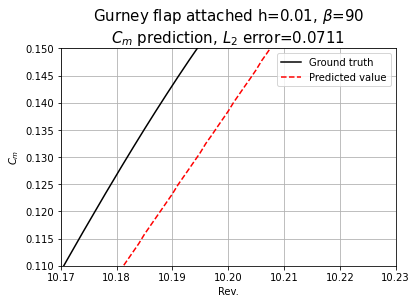

L2 error of Cm: 0.0156


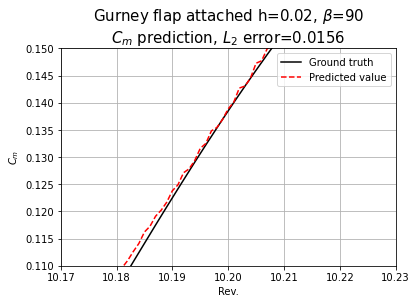

L2 error of Cm: 0.0857


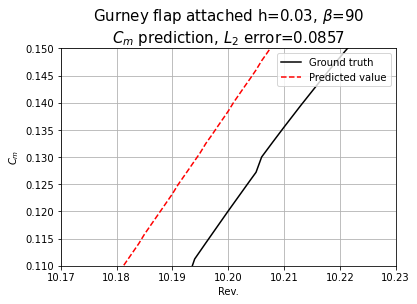

In [96]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    
    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)
        
    Cm_trainTestSplit_Plot2(i, Cm, cm_, tTrain, tVal, tTest, iTrain_, iVal_, iTest_)

L2 error of Cm: 0.0711


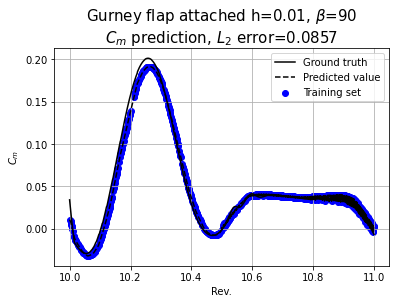

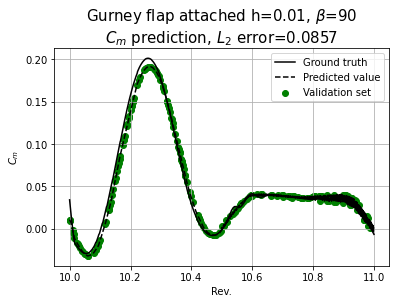

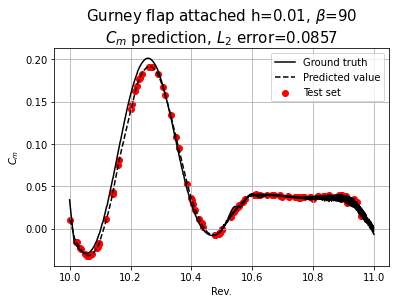

L2 error of Cm: 0.0156


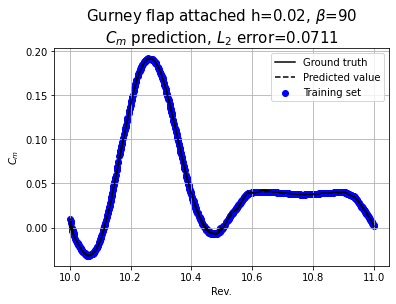

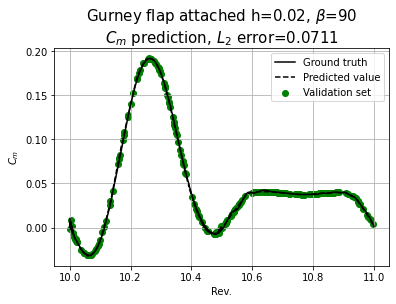

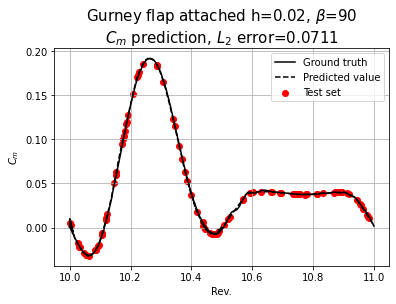

L2 error of Cm: 0.0857


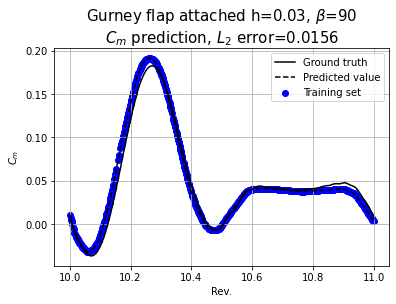

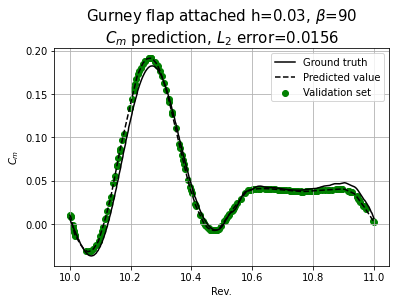

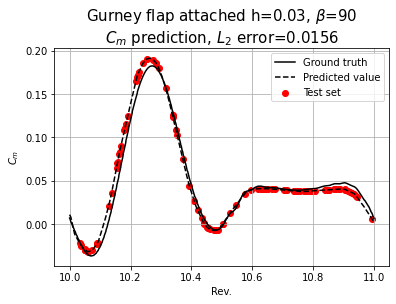

In [97]:
for i in range(0,3):
    #Index from each dataset
    iTrain_ = []
    iVal_ = []
    iTest_ = []
    
    # Index from input data (alpha, in this case)
    t_train = []
    t_val = []
    t_test = []
    title_n_Cm = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_m$ prediction, $L_2$ error=%.4f'%(l2_error_Cm)
    
    title_Cm = title_n_Cm
    savename1 = "CmComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"

    predictedValue = predicted[t_len*i:t_len*(i+1),:]
    y_corres = y[t_len*i:t_len*(i+1),:]
    
    l2_error_Cm = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    print('L2 error of Cm: {0:0.4f}'.format(l2_error_Cm))
    
    cm_ = predictedValue#denormalize(predictedValue)
    Cm = y_corres#denormalize(y_corres)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        iTrain_.append(predicted[index])
    for jj, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        iVal_.append(predicted[index])    
    for kk, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & (index_test>=i*t_len))]):
        iTest_.append(predicted[index])
        
#     iTrain = denormalize(np.array(iTrain))
#     iTest = denormalize(np.array(iTest))
#     iVal = denormalize(np.array(iVal))
    iTrain_ = np.array(iTrain_)
    iVal_ = np.array(iVal_)
    iTest_ = np.array(iTest_)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*t_len) & ((index_train>=i*t_len)))]):
        t_train.append(t[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*t_len) & ((index_val>=i*t_len)))]):
        t_val.append(t[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*t_len) & ((index_test>=i*t_len)))]):
        t_test.append(t[index])
        
    tTrain = np.array(t_train)
    tVal = np.array(t_val)
    tTest = np.array(t_test)

    # Cm graph plot
    ## Training dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    #plt.scatter(tTrain, iTrain, color='b', label='Training set')
    #plt.scatter(tVal, iVal, color='g', label='Validation set')
    plt.scatter(tTrain, denormalize(iTrain_), color='b', label='Training set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Validation dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tVal, denormalize(iVal_), color='g', label='Validation set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    
    ## Test dataset
    plt.plot(t[:1000], denormalize(Cm), 'k-', label='Ground truth')
    plt.plot(t[:1000], denormalize(cm_), 'k--', label='Predicted value')
    plt.scatter(tTest, denormalize(iTest_), color='r', label='Test set')
    plt.xlabel('Rev.')
    plt.ylabel('$C_m$')
    plt.title(title_Cm, fontsize=15)        
    plt.legend(loc='upper right')
    #plt.ylim([0, 0.0042])
    plt.grid()
    #plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()